## 1. Setup and Data Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import balanced_accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
import xgboost as xgb
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier

In [2]:
# Load data
train_df = pd.read_csv('../datasets/train_data.csv')
val_df = pd.read_csv('../datasets/val_data.csv')
feature_cols = ['Packet speed', 'Data speed', 'Packet Rate', 'Data Rate', 'Packet Size to Speed Ratio', 'Data to Packet Ratio',
                'Duration', 'Hour sin', 'Hour cos', 'Day of Week','Unique ports', 'Std packet speed', 'Max packet speed', 
                'Std data speed', 'Max data speed', 'Std packet length', 'Max packet length',
                'Std source IP count', 'Max source IP count', 'Mean time diff', 'Std time diff','pca_1','pca_2']

In [3]:
# Display a sample of the data
train_df.head()

,Unnamed: 0,Attack ID,Victim IP,Port number,Detect count,Packet speed,Data speed,Avg packet len,Avg source IP count,Start time,...,Std data speed,Max data speed,Std packet length,Max packet length,Std source IP count,Max source IP count,Mean time diff,Std time diff,pca_1,pca_2
0,0,1,IP_0001,4500,1,0.012829,0.035732,1383,6,2022-08-08 18:09:36,...,0.0,73,0.0,1383,0.0,6,0.0,0.0,5882.390147,-43.601836
1,1,2,IP_0002,4500,1,0.015076,0.044053,1506,1,2022-08-08 18:37:28,...,0.0,90,0.0,1506,0.0,1,0.0,0.0,77282.435588,23.576695
2,2,3,IP_0003,1200,2,0.014848,0.040137,1399,1,2022-08-08 18:41:25,...,3.5,86,0.0,1399,0.0,1,0.5,0.5,12982.392646,-36.872210
3,3,4,IP_0002,4500,1,0.013938,0.041605,1486,1,2022-08-08 18:47:49,...,3.5,86,0.0,1399,0.0,1,0.5,0.5,9782.400003,-39.903941
4,4,5,IP_0004,12347,2,0.019272,0.055311,1518,1,2022-08-08 18:57:15,...,0.0,85,0.0,1486,0.0,1,0.0,0.0,-48320.362374,-39.977475


## 2. Data Preparation

In [4]:
# Prepare training and testing datasets
X_train = train_df[feature_cols] 
y_train = train_df['Type']       

X_test = val_df[feature_cols]      
y_test = val_df['Type']            

# Encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

### 2.1 Feature Scaling

In [5]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### 2.2 SMOTE for Class Imbalance

In [6]:
# Check class distribution before SMOTE
print("Original class distribution:")
print(y_train.value_counts())

# Apply SMOTE
smote = SMOTE(sampling_strategy={'Normal traffic': 249013, 
                                 'Suspicious traffic': 50000, 
                                 'DDoS attack': 5000}, random_state=42)

class_mapping =  {}
for i, class_name in enumerate(le.classes_):
        class_mapping[class_name] = i
print(class_mapping)
smote_encoded = SMOTE(sampling_strategy={class_mapping['Normal traffic']: 249013,
                                        class_mapping['Suspicious traffic']: 50000,
                                        class_mapping['DDoS attack']: 5000},random_state=42)

# For regular data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# For scaled data
X_train_smote_scaled, y_train_smote_encoded = smote_encoded.fit_resample(X_train_scaled, y_train_encoded)

# Check class distribution after SMOTE
print("\nResampled class distribution:")
print(y_train_smote.value_counts())

Original class distribution:
Type
Normal traffic        249013
Suspicious traffic     13380
DDoS attack             2373
Name: count, dtype: int64
{'DDoS attack': 0, 'Normal traffic': 1, 'Suspicious traffic': 2}

Resampled class distribution:
Type
Normal traffic        249013
Suspicious traffic     50000
DDoS attack             5000
Name: count, dtype: int64


## 3. Modeling

We'll evaluate each model with:
1. Original data
2. Scaled data
3. SMOTE-resampled data
4. Scaled + SMOTE data

In [7]:
# Dictionary to store results for final comparison
results = {}

# Function to evaluate model and store results
def evaluate_model(model, X_train_data, y_train_data, X_test_data, y_test_data, model_name, data_type):
    # Train model
    model.fit(X_train_data, y_train_data)

    # Predict and evaluate
    y_pred = model.predict(X_test_data)
    accuracy = accuracy_score(y_test_data, y_pred)
    recall = recall_score(y_test_data, y_pred, average="macro")
    precision = precision_score(y_test_data, y_pred, average="macro")
    f1 = f1_score(y_test_data, y_pred, average="macro")
    conf_matrix = confusion_matrix(y_test_data, y_pred)

    # Print results
    print(f"{model_name} with {data_type}")
    print(f"Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}, F1-score: {f1:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    # Store results
    results[f"{model_name} ({data_type})"] = {
        'Accuracy': round(accuracy * 100, 2),
        'Recall': round(recall * 100, 2),
        'Precision': round(precision * 100, 2),
        'F1-score': round(f1 * 100, 2)
    }

    return model, y_pred, conf_matrix
    

def plot_conf_matrix(cm, model_name, data_type, labels):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f"{model_name} - {data_type}")
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.tight_layout()
    plt.show()

### 3.1 Random Forest

Random Forest with original data
Accuracy: 0.4376, Recall: 0.4524, Precision: 0.6563, F1-score: 0.4120
Confusion Matrix:
[[  495   541    19]
 [70866 55019     8]
 [ 1163   513  1376]]


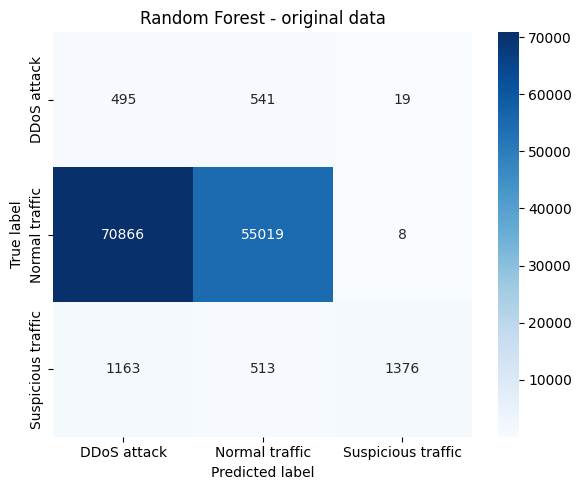

In [8]:
# 1. Random Forest with original data
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_original, y_pred_rf, conf_rf = evaluate_model(
    rf_model, X_train, y_train, X_test, y_test, 
    "Random Forest", "original data"
)
plot_conf_matrix(conf_rf, "Random Forest", "original data", le.classes_)

Random Forest with scaled data
Accuracy: 0.4356, Recall: 0.4311, Precision: 0.6556, F1-score: 0.3913
Confusion Matrix:
[[  494   539    22]
 [70935 54954     4]
 [ 1371   495  1186]]


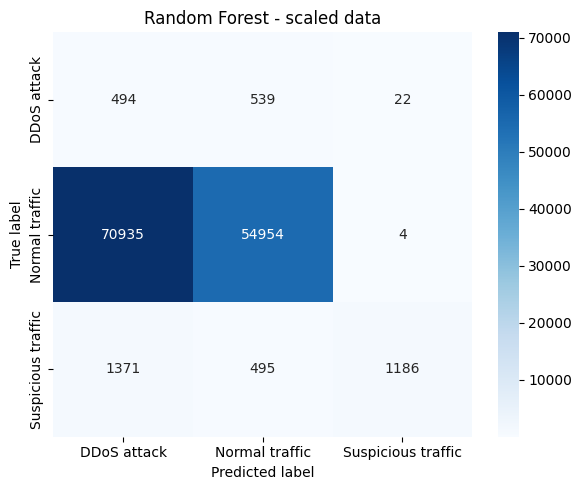

In [9]:
# 2. Random Forest with scaled data
rf_scaled = RandomForestClassifier(n_estimators=100, random_state=42)
rf_scaled_model, y_pred_rf_scaled, conf_rf_scaled = evaluate_model(
    rf_scaled, X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, 
    "Random Forest", "scaled data"
)
plot_conf_matrix(conf_rf_scaled, "Random Forest", "scaled data", le.classes_)

Random Forest with SMOTE data
Accuracy: 0.4405, Recall: 0.5383, Precision: 0.6068, F1-score: 0.4558
Confusion Matrix:
[[  522   508    25]
 [70838 54647   408]
 [  613   345  2094]]


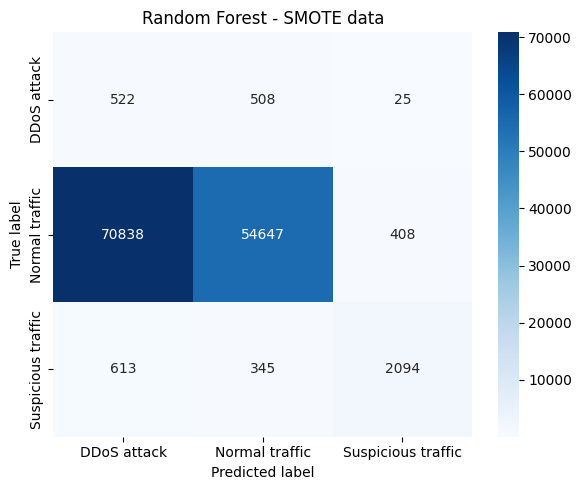

In [10]:
# 3. Random Forest with SMOTE data
rf_smote = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote_model, y_pred_rf_smote, conf_rf_smote = evaluate_model(
    rf_smote, X_train_smote, y_train_smote, X_test, y_test, 
    "Random Forest", "SMOTE data"
)
plot_conf_matrix(conf_rf_smote, "Random Forest", "SMOTE data", le.classes_)

Random Forest with SMOTE + scaled data
Accuracy: 0.4303, Recall: 0.4372, Precision: 0.6006, F1-score: 0.3788
Confusion Matrix:
[[  522   508    25]
 [71398 54244   251]
 [ 1523   351  1178]]


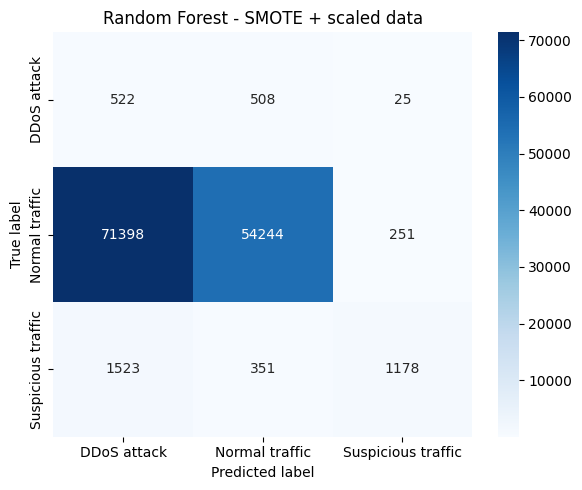

In [11]:
# 4. Random Forest with SMOTE + scaled data
rf_smote_scaled = RandomForestClassifier(n_estimators=100, random_state=42)
rf_smote_scaled_model, y_pred_rf_smote_scaled, conf_rf_smote_scaled = evaluate_model(
    rf_smote_scaled, X_train_smote_scaled, y_train_smote_encoded, X_test_scaled, y_test_encoded, 
    "Random Forest", "SMOTE + scaled data"
)
plot_conf_matrix(conf_rf_smote_scaled, "Random Forest", "SMOTE + scaled data", le.classes_)

### 3.2 SVM

LinearSVC with original data
Accuracy: 0.9695, Recall: 0.3720, Precision: 0.6575, F1-score: 0.3941
Confusion Matrix:
[[     2   1025     28]
 [     1 125686    206]
 [     2   2697    353]]


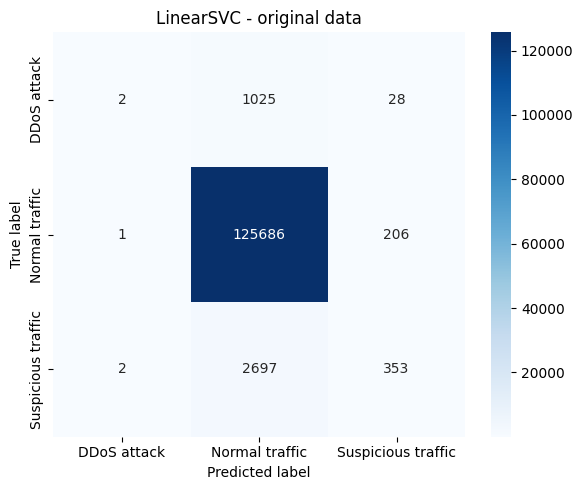

In [12]:
# 1. SVM with original data
svm_model = LinearSVC(dual=False, random_state=42, max_iter=2000)
svm_original, y_pred_svm, conf_svm = evaluate_model(
    svm_model, X_train, y_train_encoded, X_test, y_test_encoded, 
    "LinearSVC", "original data"
)
plot_conf_matrix(conf_svm, "LinearSVC", "original data", le.classes_)

LinearSVC with scaled data
Accuracy: 0.9644, Recall: 0.5228, Precision: 0.7518, F1-score: 0.4998
Confusion Matrix:
[[    17    945     93]
 [     1 123612   2280]
 [     2   1309   1741]]


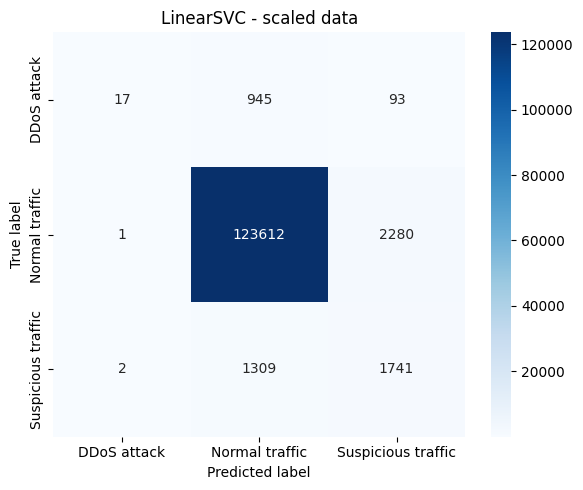

In [13]:
# 2. SVM with scaled data
svm_scaled = LinearSVC(dual=False, random_state=42, max_iter=2000)
svm_scaled_model, y_pred_svm_scaled, conf_svm_scaled = evaluate_model(
    svm_scaled, X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, 
    "LinearSVC", "scaled data"
)
plot_conf_matrix(conf_svm_scaled, "LinearSVC", "scaled data", le.classes_)

LinearSVC with SMOTE data
Accuracy: 0.9632, Recall: 0.5212, Precision: 0.5075, F1-score: 0.4931
Confusion Matrix:
[[     8    995     52]
 [    40 123454   2399]
 [    17   1279   1756]]


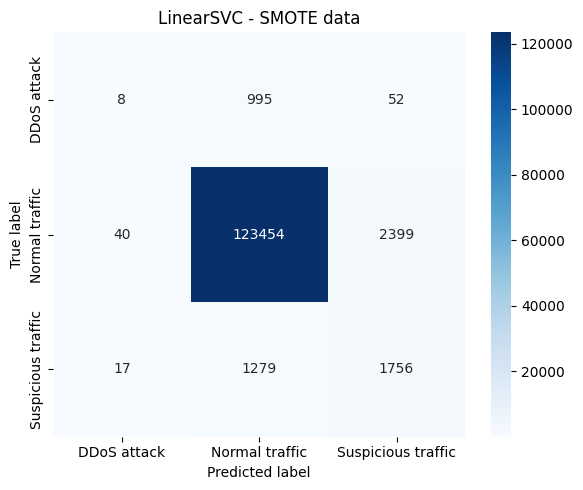

In [14]:
# 3. SVM with SMOTE data
svm_smote = LinearSVC(dual=False, random_state=42, max_iter=2000)
svm_smote_model, y_pred_svm_smote, conf_svm_smote = evaluate_model(
    svm_smote, X_train_smote, y_train_smote_encoded, X_test, y_test_encoded, 
    "LinearSVC", "SMOTE data"
)
plot_conf_matrix(conf_svm_smote, "LinearSVC", "SMOTE data", le.classes_)

LinearSVC with SMOTE + scaled data
Accuracy: 0.9485, Recall: 0.6110, Precision: 0.6816, F1-score: 0.4980
Confusion Matrix:
[[    27    873    155]
 [     5 120688   5200]
 [     5    457   2590]]


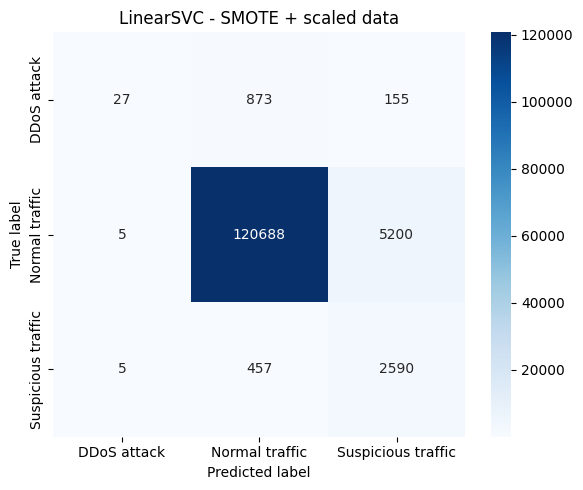

In [15]:
# 4. SVM with SMOTE + scaled data
svm_smote_scaled = LinearSVC(dual=False, random_state=42, max_iter=2000)
svm_smote_scaled_model, y_pred_svm_smote_scaled, conf_svm_smote_scaled = evaluate_model(
    svm_smote_scaled, X_train_smote_scaled, y_train_smote_encoded, X_test_scaled, y_test_encoded, 
    "LinearSVC", "SMOTE + scaled data"
)
plot_conf_matrix(conf_svm_smote_scaled, "LinearSVC", "SMOTE + scaled data", le.classes_)

### 3.3 XGBoost

XGBoost with original data
Accuracy: 0.4924, Recall: 0.4384, Precision: 0.5090, F1-score: 0.3605
Confusion Matrix:
[[  519   513    23]
 [62550 62502   841]
 [ 1506   549   997]]


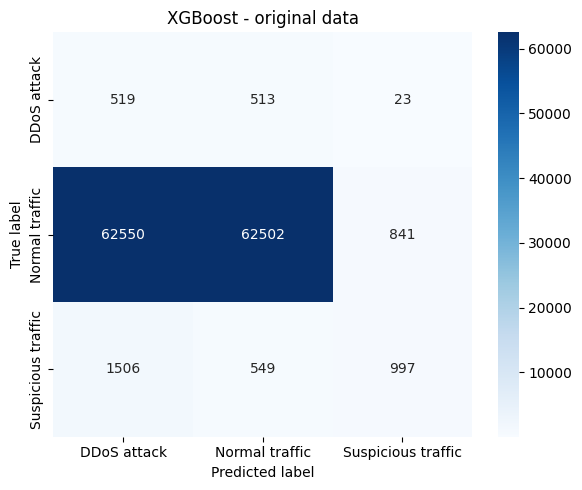

In [16]:
# 1. XGBoost with original data
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_original, y_pred_xgb, conf_xgb = evaluate_model(
    xgb_model, X_train, y_train_encoded, X_test, y_test_encoded, 
    "XGBoost", "original data"
)
plot_conf_matrix(conf_xgb, "XGBoost", "original data", le.classes_)

XGBoost with scaled data
Accuracy: 0.4628, Recall: 0.4222, Precision: 0.5058, F1-score: 0.3445
Confusion Matrix:
[[  523   510    22]
 [66369 58714   810]
 [ 1577   546   929]]


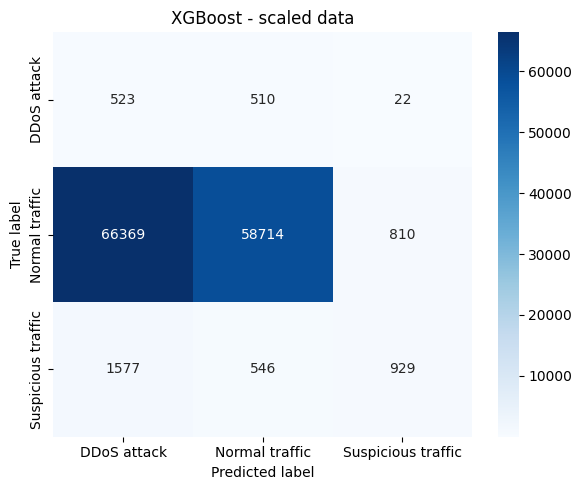

In [17]:
# 2. XGBoost with scaled data
xgb_scaled = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_scaled_model, y_pred_xgb_scaled, conf_xgb_scaled = evaluate_model(
    xgb_scaled, X_train_scaled, y_train_encoded, X_test_scaled, y_test_encoded, 
    "XGBoost", "scaled data"
)
plot_conf_matrix(conf_xgb_scaled, "XGBoost", "scaled data", le.classes_)

XGBoost with SMOTE data
Accuracy: 0.5205, Recall: 0.4789, Precision: 0.5711, F1-score: 0.4119
Confusion Matrix:
[[  514   514    27]
 [59573 65844   476]
 [ 1174   576  1302]]


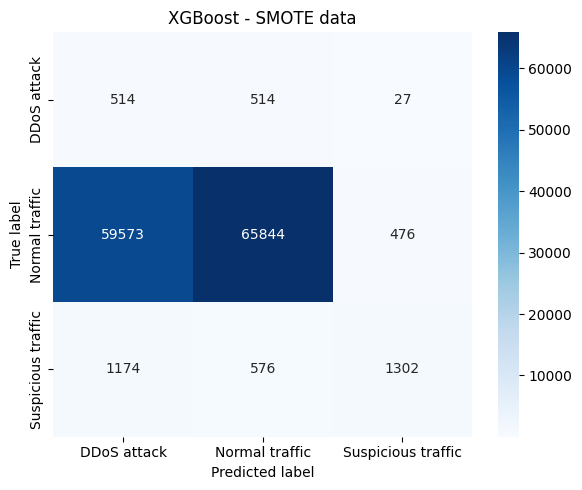

In [18]:
# 3. XGBoost with SMOTE data
xgb_smote = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_smote_model, y_pred_xgb_smote, conf_xgb_smote = evaluate_model(
    xgb_smote, X_train_smote, y_train_smote_encoded, X_test, y_test_encoded, 
    "XGBoost", "SMOTE data"
)
plot_conf_matrix(conf_xgb_smote, "XGBoost", "SMOTE data", le.classes_)

XGBoost with SMOTE + scaled data
Accuracy: 0.6860, Recall: 0.5568, Precision: 0.6148, F1-score: 0.4864
Confusion Matrix:
[[  515   502    38]
 [38485 87165   243]
 [ 1171   386  1495]]


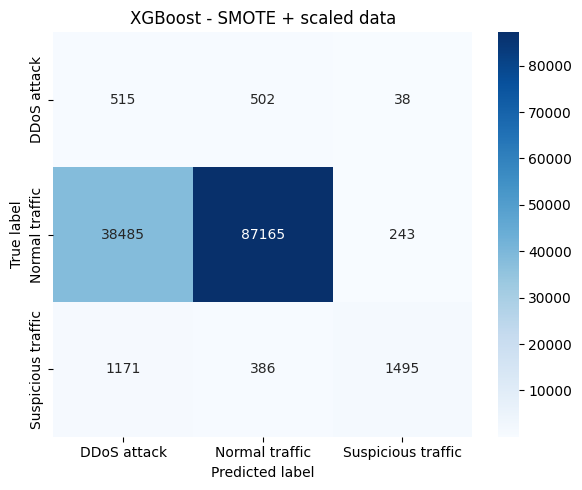

In [19]:
# 4. XGBoost with SMOTE + scaled data
xgb_smote_scaled = XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_smote_scaled_model, y_pred_xgb_smote_scaled, conf_xgb_smote_scaled = evaluate_model(
    xgb_smote_scaled, X_train_smote_scaled, y_train_smote_encoded, X_test_scaled, y_test_encoded, 
    "XGBoost", "SMOTE + scaled data"
)
plot_conf_matrix(conf_xgb_smote_scaled, "XGBoost", "SMOTE + scaled data", le.classes_)

In [20]:
# 5. Defining more models

bagging_model = BaggingClassifier(random_state=42)
ada_model = AdaBoostClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)
catboost_model = CatBoostClassifier(verbose=0, random_state=42)

voting_model = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
        ('xgb', XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)),
        ('knn', KNeighborsClassifier())
    ],
    voting='hard'
)

Bagging with original data
Accuracy: 0.4175, Recall: 0.3736, Precision: 0.6227, F1-score: 0.3119
Confusion Matrix:
[[  522   495    38]
 [72713 53129    51]
 [ 2187   242   623]]
AdaBoost with original data
Accuracy: 0.9677, Recall: 0.6205, Precision: 0.5255, F1-score: 0.5623
Confusion Matrix:
[[    30    915    110]
 [   750 123156   1987]
 [   164    279   2609]]
GradientBoosting with original data
Accuracy: 0.4273, Recall: 0.3344, Precision: 0.6227, F1-score: 0.2384
Confusion Matrix:
[[  544   502     9]
 [71032 54849    12]
 [ 2157   737   158]]
CatBoost with original data
Accuracy: 0.8493, Recall: 0.7148, Precision: 0.6686, F1-score: 0.6219
Confusion Matrix:
[[   491    533     31]
 [ 18491 107402      0]
 [   229    302   2521]]
Voting with original data
Accuracy: 0.4498, Recall: 0.3566, Precision: 0.6514, F1-score: 0.3022
Confusion Matrix:
[[  481   562    12]
 [68381 57508     4]
 [ 1951   622   479]]


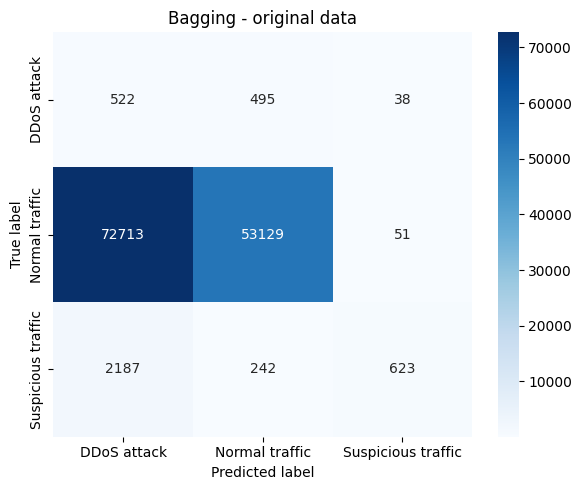

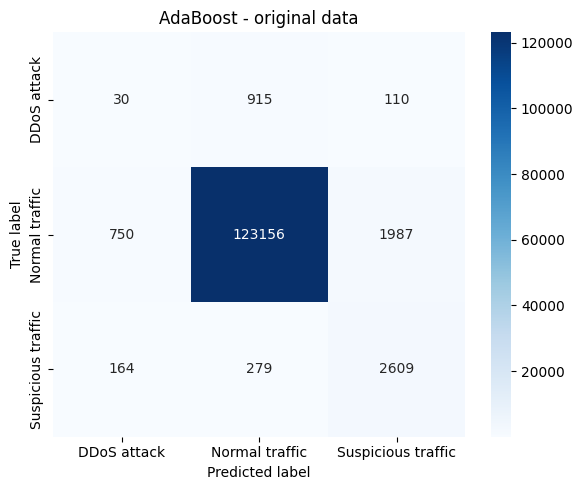

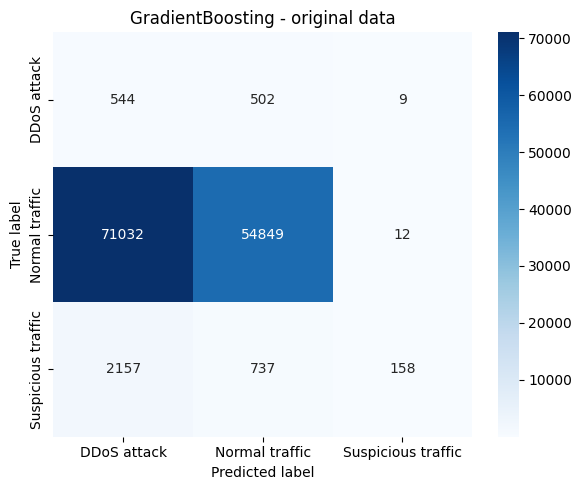

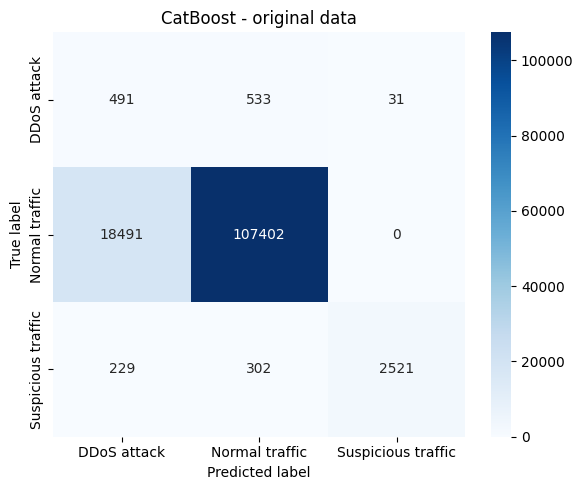

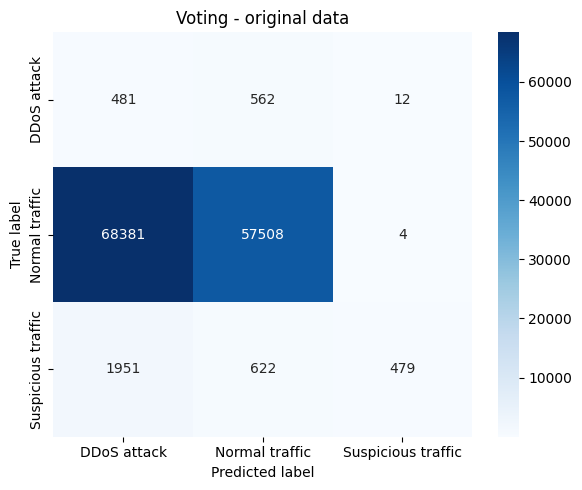

In [21]:
bagging_result, y_pred_bagging, conf_bagging = evaluate_model(
    bagging_model, X_train, y_train_encoded, X_test, y_test_encoded,
    "Bagging", "original data"
)

ada_result, y_pred_ada, conf_ada = evaluate_model(
    ada_model, X_train, y_train_encoded, X_test, y_test_encoded,
    "AdaBoost", "original data"
)

gb_result, y_pred_gb, conf_gb = evaluate_model(
    gb_model, X_train, y_train_encoded, X_test, y_test_encoded,
    "GradientBoosting", "original data"
)

catboost_result, y_pred_cat, conf_cat = evaluate_model(
    catboost_model, X_train, y_train_encoded, X_test, y_test_encoded,
    "CatBoost", "original data"
)

voting_result, y_pred_vote, conf_vote = evaluate_model(
    voting_model, X_train, y_train_encoded, X_test, y_test_encoded,
    "Voting", "original data"
)



plot_conf_matrix(conf_bagging, "Bagging", "original data", le.classes_)
plot_conf_matrix(conf_ada, "AdaBoost", "original data", le.classes_)
plot_conf_matrix(conf_gb, "GradientBoosting", "original data", le.classes_)
plot_conf_matrix(conf_cat, "CatBoost", "original data", le.classes_)
plot_conf_matrix(conf_vote, "Voting", "original data", le.classes_)


In [22]:
# Create a new voting classifier without problematic estimators
# voting_model2 = VotingClassifier(
#     estimators=[
#         ('ada', AdaBoostClassifier(random_state=42)),
#         ('cat', CatBoostClassifier(verbose=0, random_state=42)),  # Regular CatBoost
#         ('svc', SVC(probability=True, random_state=42))  # SVC with probability=True
#     ],
#     voting='hard'
# )

# voting_result2, y_pred_vote2, conf_vote2 = evaluate_model(
#     voting_model2, X_train, y_train_encoded, X_test, y_test_encoded,
#     "Voting 2", "original data"
# )

# plot_conf_matrix(conf_vote2, "Voting 2", "original data", le.classes_)

KeyboardInterrupt: 

### 3.4 Feature importances and rf with only using top features

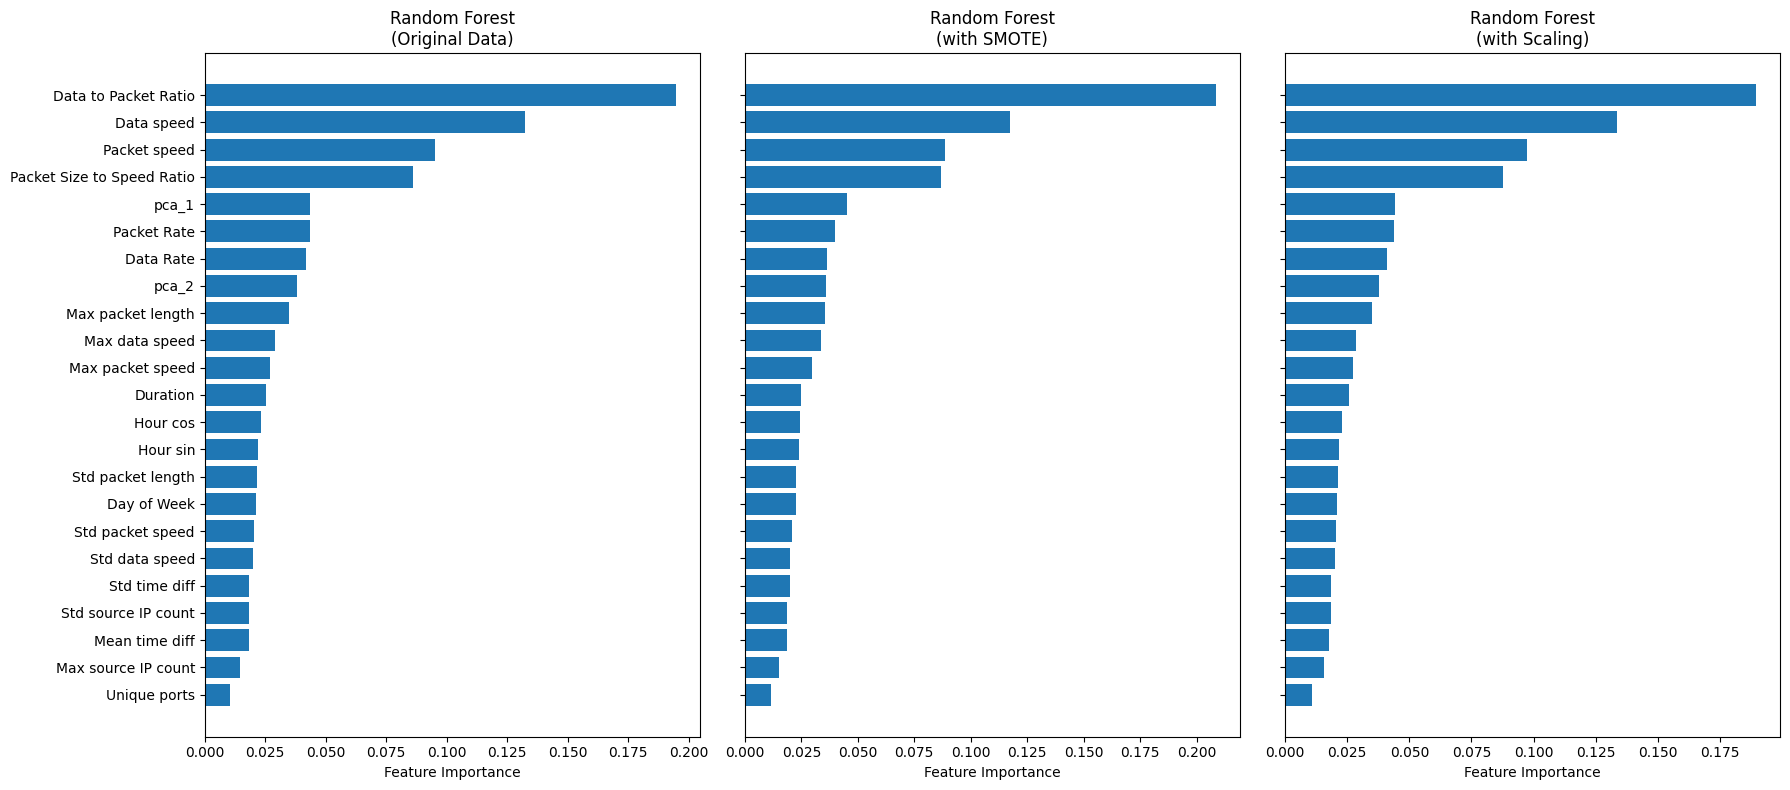

In [23]:
# Random Forest Feature Importance
feature_importances_rf = rf_original.feature_importances_
feature_importances_rf_smote = rf_smote_model.feature_importances_
feature_importances_rf_scale = rf_scaled_model.feature_importances_

# Visualize feature importance for the three RF models
fig, axes = plt.subplots(1, 3, figsize=(18, 8), sharey=True)

# Sort the features by importance for better visualization
def plot_feature_importance(ax, importances, title):
    # Create array of feature importance with feature names as index
    indices = np.argsort(importances)
    
    # Plot the feature importance in descending order
    ax.barh(range(len(importances)), importances[indices], align='center')
    ax.set_yticks(range(len(importances)))
    ax.set_yticklabels([feature_cols[i] for i in indices])
    ax.set_title(title)
    ax.set_xlabel('Feature Importance')

# Plot for the standard Random Forest model
plot_feature_importance(axes[0], feature_importances_rf, 'Random Forest\n(Original Data)')

# Plot for Random Forest with SMOTE
plot_feature_importance(axes[1], feature_importances_rf_smote, 'Random Forest\n(with SMOTE)')

# Plot for Scaled Random Forest
plot_feature_importance(axes[2], feature_importances_rf_scale, 'Random Forest\n(with Scaling)')

plt.tight_layout()
plt.show()

Random Forest with top features + scaled data
Accuracy: 0.3227, Recall: 0.3701, Precision: 0.6541, F1-score: 0.2867
Confusion Matrix:
[[  597   440    18]
 [85211 40680     2]
 [ 2163   214   675]]


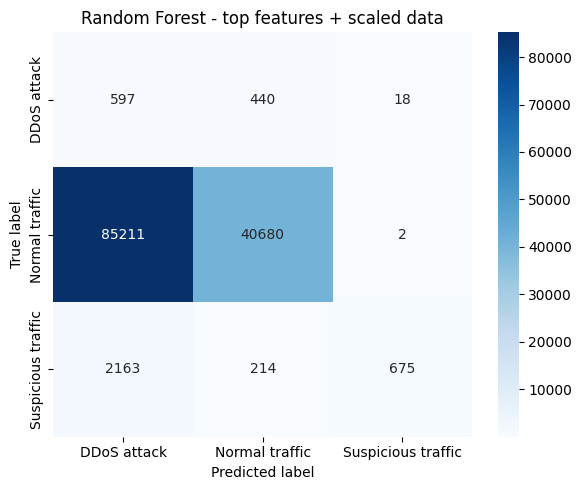

In [24]:
# Train with only the top features
top_features = ['Data to Packet Ratio', 'Data speed', 'Packet speed', 
                'Packet Size to Speed Ratio', 'pca_1', 'Packet Rate', 'pca_2']
X_train_top = X_train[top_features]
X_test_top = X_test[top_features]

# Scale these features
scaler_top = StandardScaler()
X_train_top_scaled = scaler_top.fit_transform(X_train_top)
X_test_top_scaled = scaler_top.transform(X_test_top)

# Train model with just these features
rf_top_features = RandomForestClassifier(n_estimators=100, random_state=42)
rf_top, y_pred_top, conf_top = evaluate_model(
    rf_top_features, X_train_top_scaled, y_train_encoded, X_test_top_scaled, y_test_encoded, 
    "Random Forest", "top features + scaled data"
)

plot_conf_matrix(conf_top, "Random Forest", "top features + scaled data", le.classes_)

### 3.5 Binary Classification

Random Forest Binary with scaled data (Normal vs Attack)
Accuracy: 0.3344, Recall: 0.4295, Precision: 0.4974, F1-score: 0.2553
Confusion Matrix:
[[  555   500]
 [86025 42920]]


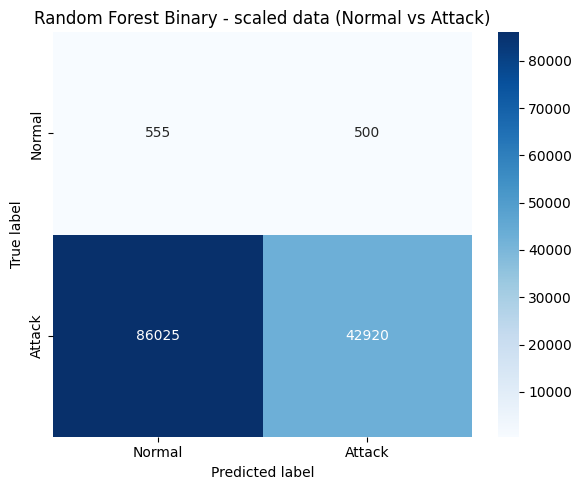

In [25]:
# Binary class version (Normal vs Any-Attack)
y_train_binary = (y_train_encoded != 0).astype(int)  # 0=Normal, 1=Any attack
y_test_binary = (y_test_encoded != 0).astype(int)

# Train binary classifier on scaled data
rf_binary = RandomForestClassifier(n_estimators=100, random_state=42)
rf_binary_model, y_pred_binary, conf_binary = evaluate_model(
    rf_binary, X_train_scaled, y_train_binary, X_test_scaled, y_test_binary, 
    "Random Forest Binary", "scaled data (Normal vs Attack)"
)

plot_conf_matrix(conf_binary, "Random Forest Binary", "scaled data (Normal vs Attack)", ["Normal", "Attack"])

### 3.6 Neural network

In [26]:
!pip install -q pytorch-lightning
!pip install tensorboardX

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pytorch_lightning as pl
import torchmetrics

In [28]:
if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

GPU is available


In [29]:
batch_size = 64
epochs = 20
lr = 0.002
hidden_dim = 64

In [30]:
X_nn_train, X_nn_val, y_nn_train, y_nn_val = train_test_split(X_train_smote_scaled, y_train_smote_encoded, test_size=0.2, random_state=42)

In [31]:
def create_dataloader(X, y, batch_size):
  X = scaler.transform(X).astype('float32')
  X = torch.from_numpy(X)
  y = y.astype('long')
  y = torch.from_numpy(y)
  dataset = TensorDataset(X, y)
  dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers = 15)
  return dataloader

train_loader = create_dataloader(X_nn_train, y_nn_train, batch_size)
val_loader = create_dataloader(X_nn_val, y_nn_val, batch_size)
test_loader = create_dataloader(X_test, y_test_encoded, batch_size)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [32]:
import pytorch_lightning as pl
import torch.nn as nn
import torchmetrics

class MyFeedForwardNet(pl.LightningModule):
    def __init__(self, num_features, hidden_dim, lr, num_classes=3):
        super(MyFeedForwardNet, self).__init__()
        self.save_hyperparameters()
        self.lr = lr
        self.num_classes = num_classes

        self.layers = nn.Sequential(
            nn.Linear(num_features, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)  # output logits for each class
        )

        self.loss = nn.CrossEntropyLoss()
        self.acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.layers(x)

    def training_step(self, batch, batch_idx):
        loss, acc = self._shared_eval_step(batch)
        self.log_dict({"loss": loss, "acc": acc}, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self._shared_eval_step(batch)
        self.log_dict({"val_loss": loss, "val_acc": acc}, prog_bar=False)
        return {"val_loss": loss, "val_acc": acc}

    def test_step(self, batch, batch_idx):
        loss, acc = self._shared_eval_step(batch)
        self.log_dict({"test_loss": loss, "test_acc": acc})
        return {"test_loss": loss, "test_acc": acc}

    def _shared_eval_step(self, batch):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = self.acc(preds, y)
        return loss, acc

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr)

In [33]:
from pytorch_lightning.loggers import CSVLogger
logger = CSVLogger(save_dir="logs/", name="ddos_logs")

In [34]:
model = MyFeedForwardNet(X_nn_train.shape[1], hidden_dim, lr)

# we use the ModelCheckpoint callback to save the best model
callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath = '',
    filename = 'best_model',
)

# we use the Trainer class to train our model
trainer = pl.Trainer(
    logger=logger,
    max_epochs=5,
    log_every_n_steps=100,
    callbacks=[callback],
    enable_progress_bar=True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [ ]:
torch.set_float32_matmul_precision('high')
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | layers | Sequential         | 1.7 K  | train
1 | loss   | CrossEntropyLoss   | 0      | train
2 | acc    | MulticlassAccuracy | 0      | train
------------------------------------------------------
1.7 K     Trainable params
0         Non-trainable params
1.7 K     Total params
0.007     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|██████████| 3801/3801 [00:42<00:00, 90.25it/s, v_num=2, loss=0.262, acc=0.900] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 3801/3801 [00:41<00:00, 92.31it/s, v_num=2, loss=0.283, acc=0.800] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 3801/3801 [00:44<00:00, 86.02it/s, v_num=2, loss=0.136, acc=0.900] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 3801/3801 [00:42<00:00, 90.47it/s, v_num=2, loss=0.267, acc=0.900] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4:  68%|██████▊   | 2593/3801 [00:29<00:13, 87.76it/s, v_num=2, loss=0.322, acc=0.891] 

In [38]:
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing DataLoader 0: 100%|██████████| 2032/2032 [00:16<00:00, 123.10it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9044384360313416     │
│         test_loss         │     1.031802773475647     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 1.031802773475647, 'test_acc': 0.9044384360313416}]

In [39]:
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        logits = model(x)
        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())

y_pred = torch.cat(all_preds).numpy()
y_true = torch.cat(all_targets).numpy()
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.03      0.27      0.06      1055
           1       0.97      0.93      0.95    125893
           2       0.01      0.00      0.00      3052

    accuracy                           0.90    130000
   macro avg       0.34      0.40      0.34    130000
weighted avg       0.94      0.90      0.92    130000



In [40]:
class FeedForwardNet(pl.LightningModule):
    def __init__(self, num_features, hidden_dim, lr, num_classes=3, dropout_prob=0.3):
        super(FeedForwardNet, self).__init__()
        self.save_hyperparameters()
        self.lr = lr
        self.num_classes = num_classes

        self.layers = nn.Sequential(
            nn.Linear(num_features, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Linear(hidden_dim, num_classes)  # output layer (logits)
        )

        self.loss = nn.CrossEntropyLoss()
        self.acc = torchmetrics.classification.Accuracy(task="multiclass", num_classes=num_classes)

    def forward(self, x):
        return self.layers(x)

    def training_step(self, batch, batch_idx):
        loss, acc = self._shared_eval_step(batch)
        self.log_dict({"loss": loss, "acc": acc}, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self._shared_eval_step(batch)
        self.log_dict({"val_loss": loss, "val_acc": acc}, prog_bar=False)
        return {"val_loss": loss, "val_acc": acc}

    def test_step(self, batch, batch_idx):
        loss, acc = self._shared_eval_step(batch)
        self.log_dict({"test_loss": loss, "test_acc": acc})
        return {"test_loss": loss, "test_acc": acc}

    def _shared_eval_step(self, batch):
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        acc = self.acc(preds, y)
        return loss, acc

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.lr)

In [41]:
model = FeedForwardNet(X_nn_train.shape[1], hidden_dim, lr)

# we use the ModelCheckpoint callback to save the best model
callback = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    dirpath = '',
    filename = 'best_model_2',
)

# we use the Trainer class to train our model
trainer = pl.Trainer(
    logger=logger,
    max_epochs=5,
    log_every_n_steps=100,
    callbacks=[callback],
    enable_progress_bar=True
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [42]:
trainer.fit(model, train_loader, val_loader)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory  exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name   | Type               | Params | Mode 
------------------------------------------------------
0 | layers | Sequential         | 6.1 K  | train
1 | loss   | CrossEntropyLoss   | 0      | train
2 | acc    | MulticlassAccuracy | 0      | train
------------------------------------------------------
6.1 K     Trainable params
0         Non-trainable params
6.1 K     Total params
0.025     Total estimated model params size (MB)
12        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Epoch 0: 100%|██████████| 3801/3801 [00:48<00:00, 78.77it/s, v_num=2, loss=2.450, acc=0.400] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 3801/3801 [00:50<00:00, 74.85it/s, v_num=2, loss=0.196, acc=0.900] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 3801/3801 [00:53<00:00, 71.52it/s, v_num=2, loss=0.377, acc=0.900] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 3801/3801 [00:54<00:00, 69.57it/s, v_num=2, loss=0.844, acc=0.600] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 3801/3801 [00:49<00:00, 77.30it/s, v_num=2, loss=0.825, acc=0.600] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 3801/3801 [00:59<00:00, 64.09it/s, v_num=2, loss=0.825, acc=0.600]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 3801/3801 [00:59<00:00, 64.09it/s, v_num=2, loss=0.825, acc=0.600]


In [43]:
trainer.test(model, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Testing DataLoader 0: 100%|██████████| 2032/2032 [00:16<00:00, 120.75it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9675846099853516     │
│         test_loss         │    0.20479752123355865    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.20479752123355865, 'test_acc': 0.9675846099853516}]

In [44]:
all_preds = []
all_targets = []

model.eval()
with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        logits = model(x)
        preds = torch.argmax(logits, dim=1)

        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())

y_pred = torch.cat(all_preds).numpy()
y_true = torch.cat(all_targets).numpy()
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.00      0.01      1055
           1       0.97      1.00      0.98    125893
           2       0.01      0.00      0.00      3052

    accuracy                           0.97    130000
   macro avg       0.53      0.33      0.33    130000
weighted avg       0.94      0.97      0.95    130000



## 4. Results Comparison

In [45]:
# Create DataFrame from results dictionary for easy comparison
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df = results_df.sort_values(by=['Recall', 'Accuracy'], ascending=False)

# Display the results
print("Models Performance Summary (Sorted by Recall)")
results_df

Models Performance Summary (Sorted by Recall)


,Accuracy,Recall,Precision,F1-score
CatBoost (original data),84.93,71.48,66.86,62.19
AdaBoost (original data),96.77,62.05,52.55,56.23
LinearSVC (SMOTE + scaled data),94.85,61.10,68.16,49.80
XGBoost (SMOTE + scaled data),68.60,55.68,61.48,48.64
Random Forest (SMOTE data),44.05,53.83,60.68,45.58
LinearSVC (scaled data),96.44,52.28,75.18,49.98
LinearSVC (SMOTE data),96.32,52.12,50.75,49.31
XGBoost (SMOTE data),52.05,47.89,57.11,41.19
Random Forest (original data),43.76,45.24,65.63,41.20
XGBoost (original data),49.24,43.84,50.90,36.05


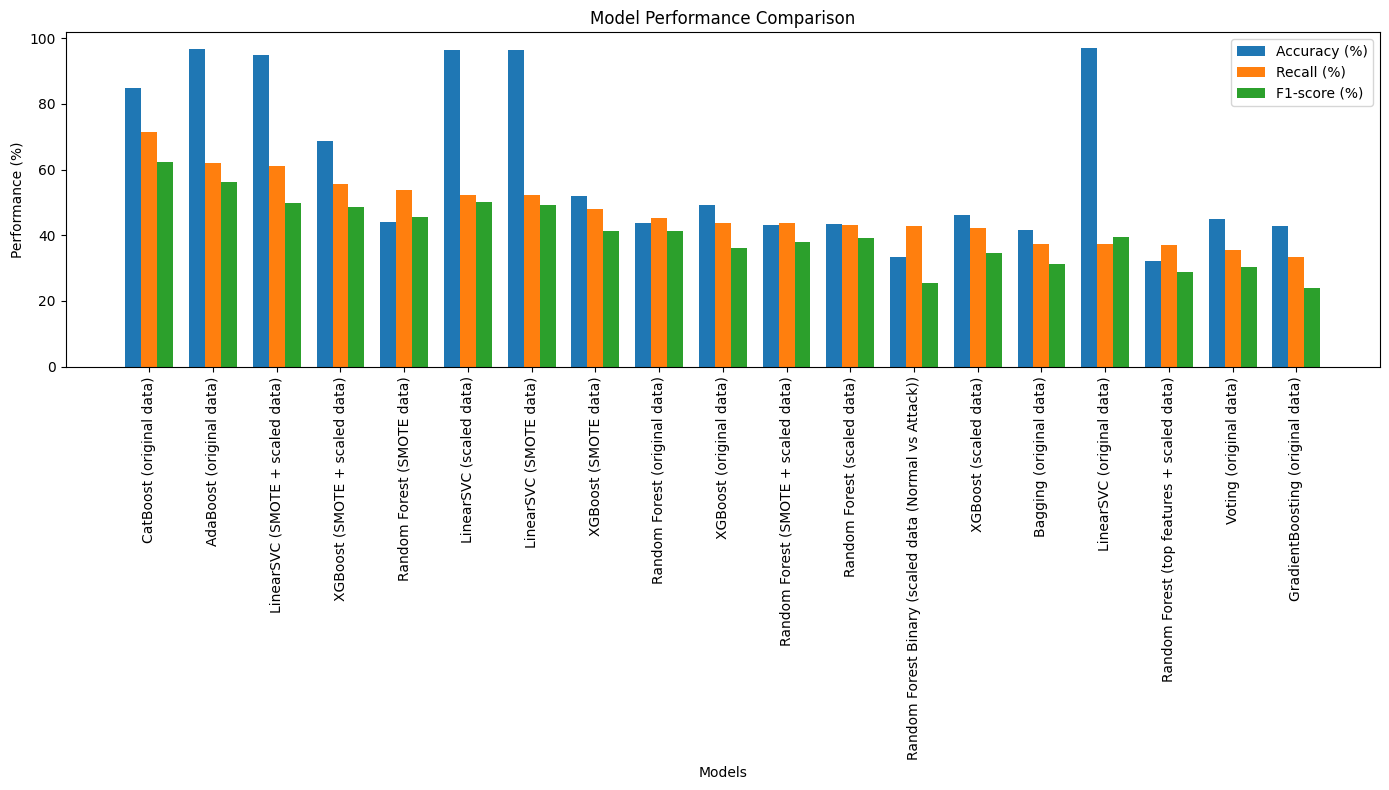

In [46]:
# Visualize the results
plt.figure(figsize=(14, 8))
bar_width = 0.25
index = np.arange(len(results_df))

plt.bar(index, results_df['Accuracy'], bar_width, label='Accuracy (%)')
plt.bar(index + bar_width, results_df['Recall'], bar_width, label='Recall (%)')
plt.bar(index + 2 * bar_width, results_df['F1-score'], bar_width, label='F1-score (%)')

plt.xlabel('Models')
plt.ylabel('Performance (%)')
plt.title('Model Performance Comparison')
plt.xticks(index + bar_width, results_df.index, rotation=90)
plt.legend()
plt.tight_layout()
plt.show()

# Szűrés

In [48]:
train_df_filtered = train_df[train_df['Avg packet len'] != 0].reset_index(drop=True)
val_df_filtered = val_df[val_df['Avg packet len'] != 0].reset_index(drop=True)

In [49]:
# Prepare training and testing datasets
X_train = train_df_filtered[feature_cols] 
y_train = train_df_filtered['Type']       

X_test = val_df_filtered[feature_cols]      
y_test = val_df_filtered['Type']            

# Encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

AdaBoost with original data
Accuracy: 0.9794, Recall: 0.4067, Precision: 0.6567, F1-score: 0.4347
Confusion Matrix:
[[    83    787     13]
 [   959 124934      0]
 [   132    736    134]]
CatBoost with original data
Accuracy: 0.8395, Recall: 0.5909, Precision: 0.6608, F1-score: 0.5413
Confusion Matrix:
[[   361    508     14]
 [ 19506 106386      1]
 [   183    299    520]]


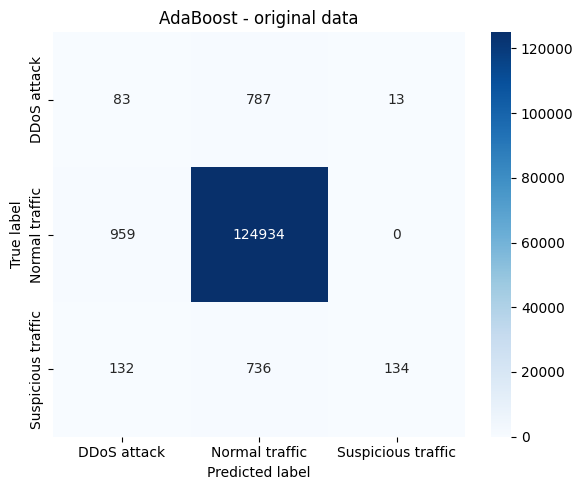

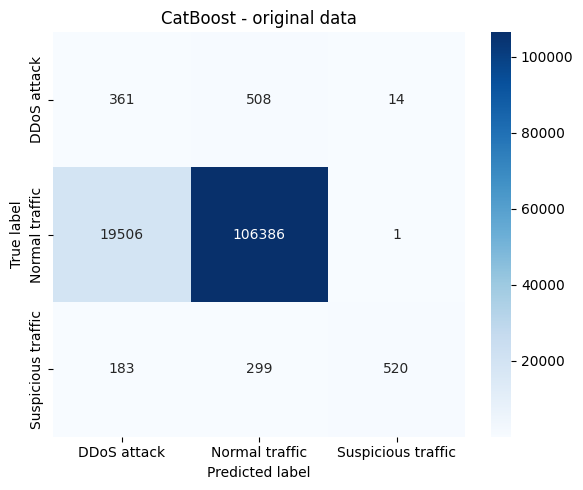

In [51]:
ada_result, y_pred_ada, conf_ada = evaluate_model(
    ada_model, X_train, y_train_encoded, X_test, y_test_encoded,
    "AdaBoost", "original data"
)

catboost_result, y_pred_cat, conf_cat = evaluate_model(
    catboost_model, X_train, y_train_encoded, X_test, y_test_encoded,
    "CatBoost", "original data"
)

plot_conf_matrix(conf_ada, "AdaBoost", "original data", le.classes_)
plot_conf_matrix(conf_cat, "CatBoost", "original data", le.classes_)

In [52]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [53]:
y_train.value_counts()

Type
Normal traffic        211202
Suspicious traffic      9834
DDoS attack             1476
Name: count, dtype: int64

In [54]:
# Check class distribution before SMOTE
print("Original class distribution:")
print(y_train.value_counts())

# Apply SMOTE
smote = SMOTE(sampling_strategy={'Normal traffic': 211202, 
                                 'Suspicious traffic': 50000, 
                                 'DDoS attack': 5000}, random_state=42)

class_mapping =  {}
for i, class_name in enumerate(le.classes_):
        class_mapping[class_name] = i
print(class_mapping)
smote_encoded = SMOTE(sampling_strategy={class_mapping['Normal traffic']: 211202,
                                        class_mapping['Suspicious traffic']: 50000,
                                        class_mapping['DDoS attack']: 5000},random_state=42)

# For regular data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# For scaled data
X_train_smote_scaled, y_train_smote_encoded = smote_encoded.fit_resample(X_train_scaled, y_train_encoded)

# Check class distribution after SMOTE
print("\nResampled class distribution:")
print(y_train_smote.value_counts())

Original class distribution:
Type
Normal traffic        211202
Suspicious traffic      9834
DDoS attack             1476
Name: count, dtype: int64
{'DDoS attack': 0, 'Normal traffic': 1, 'Suspicious traffic': 2}

Resampled class distribution:
Type
Normal traffic        211202
Suspicious traffic     50000
DDoS attack             5000
Name: count, dtype: int64


/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AdaBoost with original data
Accuracy: 0.9852, Recall: 0.3333, Precision: 0.3284, F1-score: 0.3309
Confusion Matrix:
[[     0    883      0]
 [     0 125893      0]
 [     0   1002      0]]
CatBoost with original data
Accuracy: 0.0069, Recall: 0.3318, Precision: 0.3356, F1-score: 0.0046
Confusion Matrix:
[[   879      0      4]
 [125892      1      0]
 [  1002      0      0]]


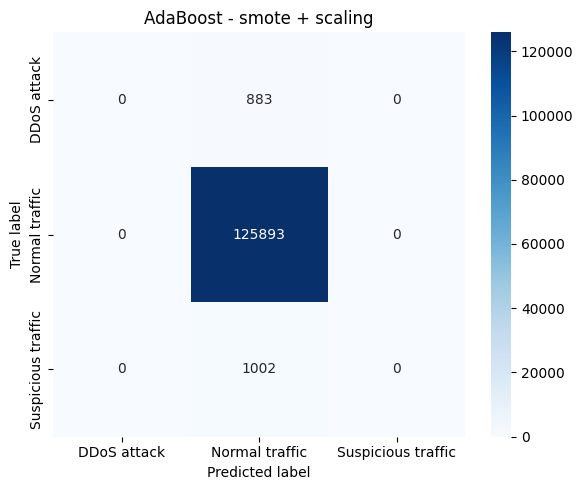

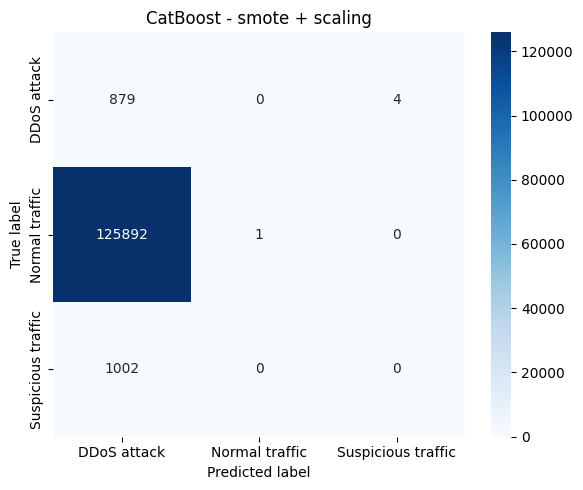

In [57]:
ada_result, y_pred_ada, conf_ada = evaluate_model(
    ada_model, X_train_smote_scaled, y_train_smote_encoded, X_test, y_test_encoded,
    "AdaBoost", "original data"
)

catboost_result, y_pred_cat, conf_cat = evaluate_model(
    catboost_model, X_train_smote_scaled, y_train_smote_encoded, X_test, y_test_encoded,
    "CatBoost", "original data"
)

plot_conf_matrix(conf_ada, "AdaBoost", "smote + scaling", le.classes_)
plot_conf_matrix(conf_cat, "CatBoost", "smote + scaling", le.classes_)

LinearSVC with SMOTE + scaled data
Accuracy: 0.9641, Recall: 0.4519, Precision: 0.4892, F1-score: 0.4029
Confusion Matrix:
[[    37    717    129]
 [    56 122815   3022]
 [     4    659    339]]


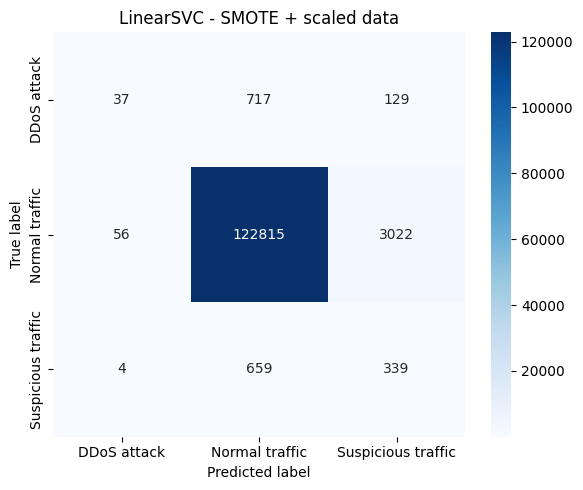

In [56]:
svm_smote_scaled = LinearSVC(dual=False, random_state=42, max_iter=2000)
svm_smote_scaled_model, y_pred_svm_smote_scaled, conf_svm_smote_scaled = evaluate_model(
    svm_smote_scaled, X_train_smote_scaled, y_train_smote_encoded, X_test_scaled, y_test_encoded, 
    "LinearSVC", "SMOTE + scaled data"
)
plot_conf_matrix(conf_svm_smote_scaled, "LinearSVC", "SMOTE + scaled data", le.classes_)